In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, Lars, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

## ОСНОВНАЯ ЧАСТЬ

#### 1. Загрузить файл ‘house_price.csv’.

In [2]:
data = pd.read_csv('house_price.csv')
data.set_index('id', inplace=True)
data.head()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,Косметический,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
id,,,,,,,,,,,,,,,,,,,,,
896,2,0,46.0,3,5,0,0,0,0,1,...,2,3,0,7,3,13,2,7,18,2350000.0
399,2,0,44.6,5,5,0,0,0,0,1,...,3,5,0,7,3,11,1,4,11,1799000.0
1515,2,0,53.0,1,9,0,1,0,0,0,...,4,11,0,5,3,17,3,7,15,2800000.0
1216,2,0,64.0,4,5,0,0,0,1,0,...,31,5,1,55,2,10,28,32,17,3970000.0
677,1,0,33.3,1,10,0,0,1,0,0,...,1,3,0,2,3,9,0,3,6,1880000.0


### 2. Проверить данные на наличие пропусков и выбросов. Обработать пропуски и выбросы.

#### 2.1 Проверяем данные на наличие пропусков функцией info

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 808 entries, 896 to 458
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    int64  
 4   Этажей.в.доме              808 non-null    int64  
 5   Парковка                   808 non-null    int64  
 6   Без.ремонта                808 non-null    int64  
 7   Дизайнерский               808 non-null    int64  
 8   Евроремонт                 808 non-null    int64  
 9   Косметический              808 non-null    int64  
 10  Балкон                     808 non-null    int64  
 11  Лоджия                     808 non-null    int64  
 12  Совмещенный.санузел        808 non-null    int64  
 13  Раздельный.санузел         808 non-null    int64  
 1

Результат: Пропуски отсутствуют.

#### 2.2 проверяем данные на наличие выбросов с помощью IQR

In [4]:
def IRQ_boundaries(col):
    IQR = col.quantile(0.75) - col.quantile(0.25)
    min_boundary = col.quantile(0.25) - 3*IQR
    max_boundary = col.quantile(0.75) + 3*IQR
    return min_boundary, max_boundary

def test_outliers(col):
    min_boundary, max_boundary = IRQ_boundaries(col)
    return ((col < min_boundary) & (col > max_boundary)).any()

* выделим столбцы с числовыми значениями

In [5]:
data_numeric_only = data.select_dtypes(include='number')
data_numeric_only

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,Косметический,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
id,,,,,,,,,,,,,,,,,,,,,
896,2,0,46.0,3,5,0,0,0,0,1,...,2,3,0,7,3,13,2,7,18,2350000.0
399,2,0,44.6,5,5,0,0,0,0,1,...,3,5,0,7,3,11,1,4,11,1799000.0
1515,2,0,53.0,1,9,0,1,0,0,0,...,4,11,0,5,3,17,3,7,15,2800000.0
1216,2,0,64.0,4,5,0,0,0,1,0,...,31,5,1,55,2,10,28,32,17,3970000.0
677,1,0,33.3,1,10,0,0,1,0,0,...,1,3,0,2,3,9,0,3,6,1880000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,1,0,38.0,6,9,0,0,0,0,1,...,2,0,0,2,0,8,0,3,5,1700000.0
562,3,0,46.0,4,4,1,0,0,0,1,...,45,8,1,19,3,13,4,10,17,2400000.0
407,1,0,34.0,9,16,0,0,0,0,1,...,0,0,0,0,1,5,1,0,3,1950000.0


In [6]:
data_numeric_only.apply(test_outliers)

Количество.комнат            False
Студия                       False
Общая.площадь                False
Этаж                         False
Этажей.в.доме                False
Парковка                     False
Без.ремонта                  False
Дизайнерский                 False
Евроремонт                   False
Косметический                False
Балкон                       False
Лоджия                       False
Совмещенный.санузел          False
Раздельный.санузел           False
Лифт                         False
Грузовой.лифт                False
Мусоропровод                 False
Год.постройки                False
Аварийный                    False
Железобетонные.перекрытия    False
Смешанные.перекрытия         False
Деревянные.перекрытия        False
Иные.перекрытия              False
Панельные.стены              False
Блочные.стены                False
Деревянные.стены             False
Кирпичные.стены              False
Монолитные.стены             False
Смешанные.стены     

Результат: Выбросы отсутствуют

### 3. Проверить данные на наличие коллинеарности. Обработать коррелирующие признаки.

In [7]:
cm = np.corrcoef(data.values.T)
cm

array([[ 1.        , -0.21549438,  0.82877221, ...,  0.23814462,
         0.22416718,  0.71522897],
       [-0.21549438,  1.        , -0.28510902, ..., -0.06455158,
        -0.08803101, -0.26301579],
       [ 0.82877221, -0.28510902,  1.        , ...,  0.22323646,
         0.23028266,  0.93859728],
       ...,
       [ 0.23814462, -0.06455158,  0.22323646, ...,  1.        ,
         0.63459678,  0.29434625],
       [ 0.22416718, -0.08803101,  0.23028266, ...,  0.63459678,
         1.        ,  0.2998905 ],
       [ 0.71522897, -0.26301579,  0.93859728, ...,  0.29434625,
         0.2998905 ,  1.        ]])

(<Figure size 1500x1500 with 2 Axes>, <Axes: >)

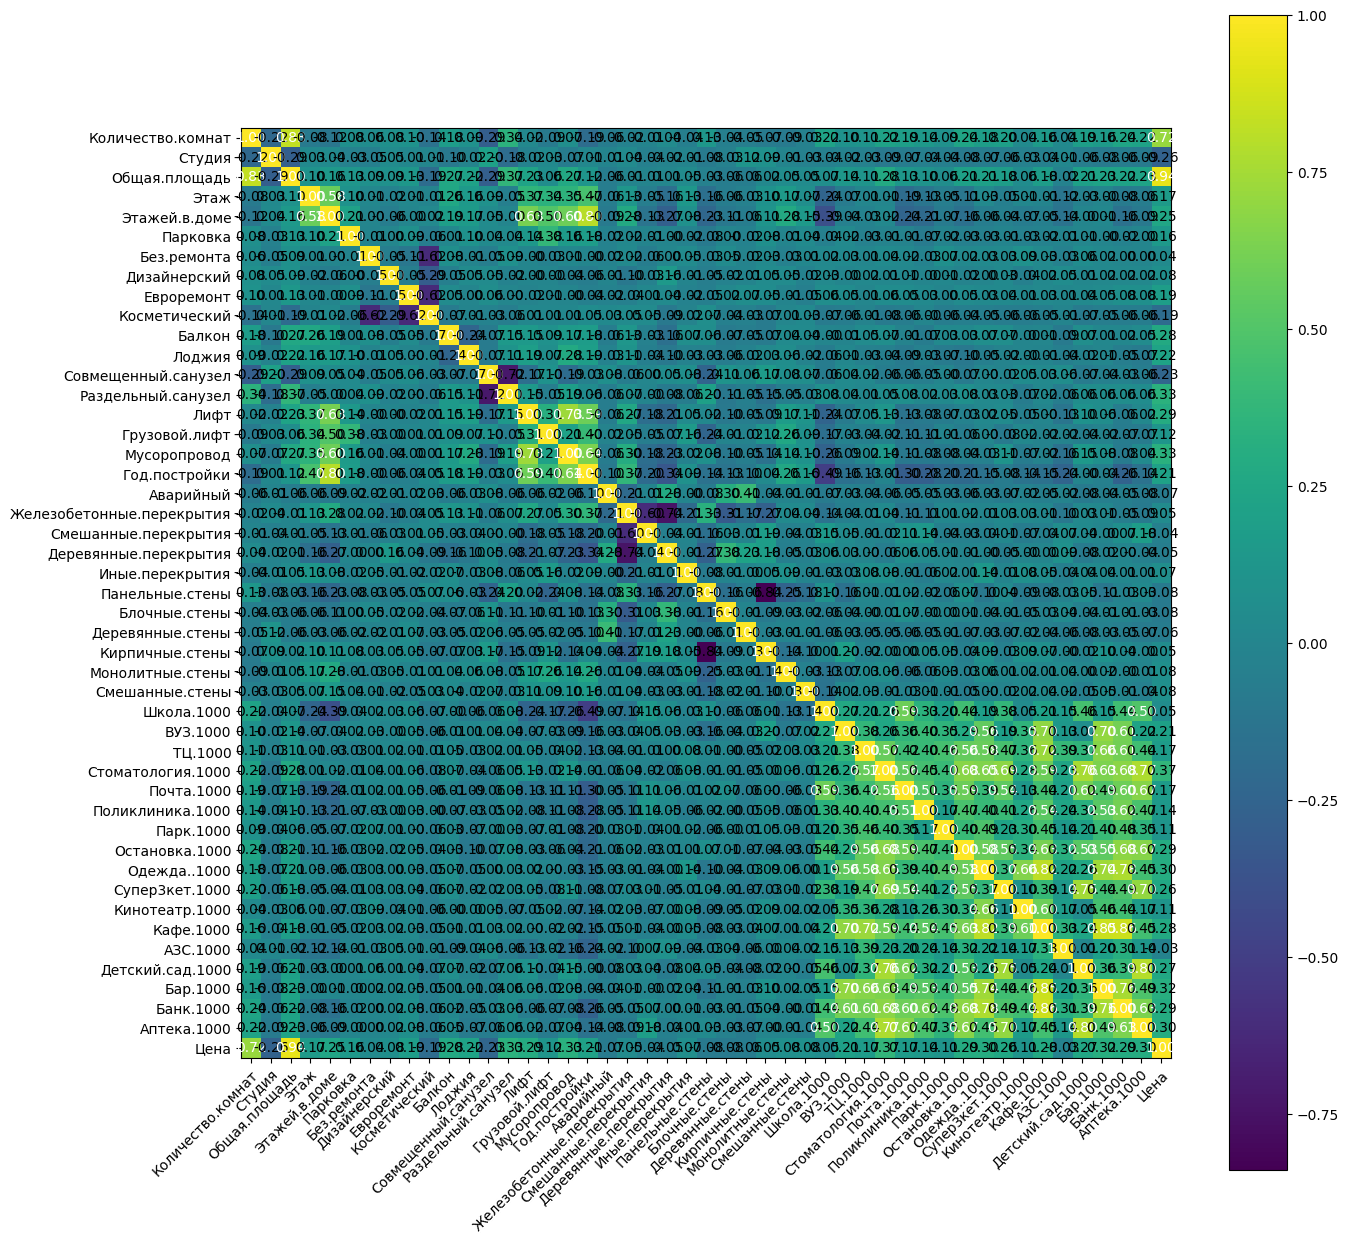

In [8]:
heatmap(cm, figsize=(15,15), row_names=data.columns, column_names=data.columns)

#### Найдем признаки для которых коэффициент корреляции больше 0.7

In [9]:
cm_no_diag = np.array([cm[x,y]  if x > y else 0 for x in range(cm.shape[0]) for y in range(cm.shape[0])]).reshape(cm.shape)

(<Figure size 640x480 with 2 Axes>, <Axes: >)

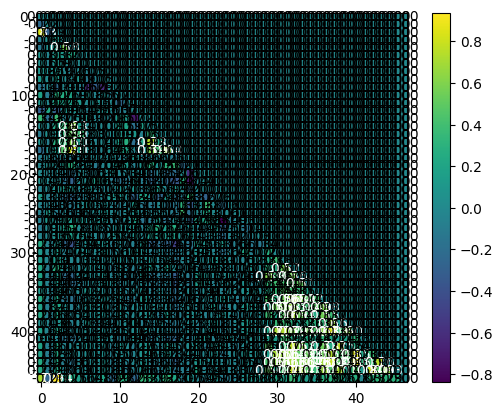

In [10]:
heatmap(cm_no_diag, )

In [12]:
columns_to_delete = []
output_row = cm_no_diag[-1]
for x, row in enumerate(cm_no_diag[0:-1]):
    for y, col in enumerate(row):
        if cm_no_diag[x, y] > 0.7:
            to_delete = x if output_row[x] < output_row[y] else y
            columns_to_delete.append(to_delete)
columns_to_delete

[0, 14, 17, 31, 40, 42, 38, 30, 37, 40, 44, 40, 44, 45, 38, 42]

In [13]:
data_uncorr = data.copy()
data_uncorr = data_uncorr.drop(data_uncorr.columns[columns_to_delete], axis=1)

In [14]:
data_uncorr.head()

,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,Косметический,Балкон,...,Школа.1000,Стоматология.1000,Почта.1000,Поликлиника.1000,Парк.1000,Остановка.1000,Кинотеатр.1000,АЗС.1000,Бар.1000,Цена
id,,,,,,,,,,,,,,,,,,,,,
896,0,46.0,3,5,0,0,0,0,1,1,...,8,7,3,1,1,11,0,3,2,2350000.0
399,0,44.6,5,5,0,0,0,0,1,1,...,3,5,2,2,1,8,0,3,1,1799000.0
1515,0,53.0,1,9,0,1,0,0,0,0,...,6,8,4,6,1,13,0,3,3,2800000.0
1216,0,64.0,4,5,0,0,0,1,0,1,...,5,15,3,7,1,16,1,2,28,3970000.0
677,0,33.3,1,10,0,0,1,0,0,0,...,1,2,1,1,0,2,0,3,0,1880000.0


### 4. Выполнить кодирование категориальных переменных.

Категориальные переменные уже закодированы

In [15]:
data_uncorr.head()

,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,Косметический,Балкон,...,Школа.1000,Стоматология.1000,Почта.1000,Поликлиника.1000,Парк.1000,Остановка.1000,Кинотеатр.1000,АЗС.1000,Бар.1000,Цена
id,,,,,,,,,,,,,,,,,,,,,
896,0,46.0,3,5,0,0,0,0,1,1,...,8,7,3,1,1,11,0,3,2,2350000.0
399,0,44.6,5,5,0,0,0,0,1,1,...,3,5,2,2,1,8,0,3,1,1799000.0
1515,0,53.0,1,9,0,1,0,0,0,0,...,6,8,4,6,1,13,0,3,3,2800000.0
1216,0,64.0,4,5,0,0,0,1,0,1,...,5,15,3,7,1,16,1,2,28,3970000.0
677,0,33.3,1,10,0,0,1,0,0,0,...,1,2,1,1,0,2,0,3,0,1880000.0


### 5. Выполнить масштабирование признаков.

Проведем масшабирование с использованием z-преобразования

In [16]:
X = data_uncorr.drop(['Цена'], axis=1).values
y = data_uncorr['Цена'].values

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1))

train_X, test_X, train_y, test_y = train_test_split(X, y)

In [17]:
X.shape, y.shape

((808, 35), (808, 1))

In [18]:
train_X.shape, train_y.shape

((606, 35), (606, 1))

### 6. Построить следующие регрессионные модели с параметрами, подобранными на кросс-валидации: линейная регрессия, лассо регрессия, гребневая регрессия, SVR, непараметрическая регрессия.

* Линейная регрессия

In [19]:
model = LinearRegression()
param_grid = {'fit_intercept': [True, False],
              'positive' : [True, False]}
search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=10, n_jobs=-1)
search.fit(train_X, train_y)

GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='r2')

In [20]:
model_lr = search.best_estimator_
model_lr.fit(train_X, train_y)

LinearRegression(fit_intercept=False)

* Лассо регрессия

In [21]:
model_ls = Lasso()
param_grid = {'alpha': [0, 0.01, 0.1, 1 ,10],
              'fit_intercept': [True, False],
              'positive' : [True, False]}
search = GridSearchCV(estimator=model_ls, param_grid=param_grid, scoring='r2', cv=10, n_jobs=-1)
search.fit(train_X, train_y)

GridSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='r2')

In [22]:
model_ls = search.best_estimator_
model_ls.fit(train_X, train_y)

Lasso(alpha=0.01, fit_intercept=False)

* Непараметрическая регрессия

In [23]:
model_knn = KNeighborsRegressor()
model_knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [24]:
param_grid  = {
    'n_neighbors' : [1, 3, 5, 7, 9, 11],
    'weights' : ['uniform', 'distance']
}
search = GridSearchCV(estimator=model_knn, param_grid=param_grid, scoring='r2',cv=10, n_jobs=-1)
search.fit(train_X, train_y)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='r2')

In [25]:
model_knn = search.best_estimator_
model_knn.fit(train_X, train_y)

KNeighborsRegressor(weights='distance')

#### 7. Спрогнозировать значение выходной переменной для тестовой выборки

In [26]:
lr_pred = model_lr.predict(test_X)
lasso_pred = model_ls.predict(test_X)
knnr_pred = model_knn.predict(test_X)

### 8. Рассчитать значения метрик качества. Выделить наилучшую модель.


In [27]:
def calc_scores(y, y_pred):
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    return r2, mae, mse

def print_scores(y, y_pred, model_name):
    r2, mae, mse = calc_scores(y, y_pred)
    print('Метрики ' + model_name)
    print(f'R2: {r2: .3f}')
    print(f'MAE: {mae: .3f}')
    print(f'MSE: {mse: .3f}')

In [28]:
print_scores(test_y, lr_pred, "Линейная регрессия")
print_scores(test_y, lasso_pred, "Лассо регрессия")
print_scores(test_y, knnr_pred, "KNN регрессия")

Метрики Линейная регрессия
R2:  0.905
MAE:  0.224
MSE:  0.088
Метрики Лассо регрессия
R2:  0.906
MAE:  0.225
MSE:  0.087
Метрики KNN регрессия
R2:  0.613
MAE:  0.445
MSE:  0.356
